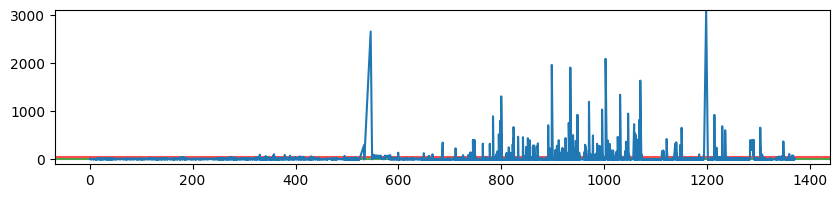

312.212
50
5.322128087550927
9.394738190716565


In [1]:
# KVM에서 발생하는 VMEXIT 중 page fault로 인한 것을 확인하기 위한 그래프 (시간 단위로 plt)

from parse import *
import numpy as np
import matplotlib.pyplot as plt

start_time = 0
end_time = 0
pf_time = 0
cpu = [] 
pf_time = []

# timestamp in <secs>.<usecs> format
#f = open("./recognition_ssd.trace", 'r')
f = open("./recognition_nvme.trace", 'r')
#f = open("./recognition_dcpm.trace", 'r')
#f = open("./recognition_faasnap.trace", 'r')


while True:
    line = f.readline()
    if not line: break

    if 'restart' in line:
        # fc_vcpu 0-552219  [040] .... 97836.519114: kvm_userspace_exit: reason restart (4)
        if start_time == 0:
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_userspace_exit: {}", line)
            start_time = int(result['sec']) * 1000000 + int(result['micro'])
        elif end_time == 0:
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_userspace_exit: {}", line)
            end_time = int(result['sec']) * 1000000 + int(result['micro'])
            

    if 'fc_vcpu 0' in line:
        if 'kvm_entry' in line:
            #fc_vcpu 0-2779478 [077] d... 1820822.383974: kvm_entry: vcpu 0
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_entry: {}", line)
            cpu_active = {'start': int(result['sec']) * 1000000 + int(result['micro']), 'end': 0, 'reason':''}
            cpu.append(cpu_active)


        if 'kvm_exit' in line:
            #fc_vcpu 0-2779478 [077] .... 1820822.383989: kvm_exit: vcpu 0 reason EPT_VIOLATION rip 0x5a1b20 info 384 0
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_exit: {} reason {reason} rip {}", line)
            # if result['reason'] == 'EPT_VIOLATION':
            reason = result['reason']
            if cpu[-1]['end'] == 0:
                cpu[-1]['reason'] = reason
                cpu[-1]['end'] = int(result['sec']) * 1000000 + int(result['micro'])
            else:
                print("Error")
                #print("vcpu exit가 더 빠름")
                

f.close()

start = []
for cpu_active in cpu:
    if cpu_active['reason'] == "EPT_VIOLATION":
    #if cpu_active['reason'] != "EPT_VIOLATION":
        cpu_active['start'] = (cpu_active['start'] - start_time) 
        cpu_active['end'] = (cpu_active['end'] - start_time)
        pf_time.append(cpu_active['end'] - cpu_active['start'])
        start.append(cpu_active['start'] * 0.001)

fig = plt.figure(figsize=(10,2)) ## 캔버스 생성

avg = np.average(pf_time)
sum = np.sum(pf_time)
np.sort(pf_time)
avg_of_1 = np.sort(pf_time)[::-1][int(0.01* len(pf_time))]

plt.axhline(y = avg,  color ='green', alpha = 0.7)
plt.axhline(y = avg_of_1,  color ='red', alpha = 0.7)

plt.ylim([-100, max(pf_time)])  

plt.plot(start, pf_time)

plt.show()
print(sum * 0.001)
print(avg_of_1)
print(avg)
print(avg_of_1 * (len(pf_time) * 0.01)/sum * 100)
#print(sum * 0.001)

